<a href="https://colab.research.google.com/github/junfrankohara/neutrophils_detection/blob/main/neutrophils_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# バーチャルスライドを開くためのライブラリをインストール

!apt update && apt install -y openslide-tools
!pip install openslide-python

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists... Done
Building dependency tree       
Reading state information... Done
23 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
R

In [2]:
# git の release から使用するモデルとサンプル画像のロード
import urllib.request
%cd /content/
%mkdir demo
print("サンプル画像のダウンロード...")
sample_url = "https://github.com/junfrankohara/neutrophils_detection/releases/download/sample_wsi/sample.ndpi"
urllib.request.urlretrieve(sample_url, './demo/sample.ndpi')
print("セグメンテーションモデルのダウンロード...")
seg_url = "https://github.com/junfrankohara/neutrophils_detection/releases/download/model2/seg_model.pth"
urllib.request.urlretrieve(seg_url, './demo/seg_model.pth')
print("好中球検出モデルののダウンロード...")
detection_url = "https://github.com/junfrankohara/neutrophils_detection/releases/download/model/neu_model.pt"
urllib.request.urlretrieve(detection_url, './demo/neu_model.pt')
%ls /content/demo


/content
mkdir: cannot create directory ‘demo’: File exists
neu_model.pt  sample2.ndpi  seg_model.pth


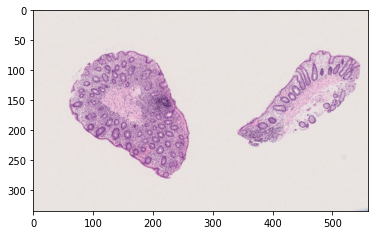

In [3]:
# openslide ファイルを開く
import matplotlib.pyplot as plt
import openslide
import numpy as np

wsi = '/content/demo/sample.ndpi'
slide = openslide.open_slide(wsi)
shapes=list(slide.level_dimensions)
level5=slide.read_region((0,0), 5, shapes[5])
image = np.array(level5)
image=image[:,:,0:3]
small_img = np.array(image)
plt.imshow(small_img)

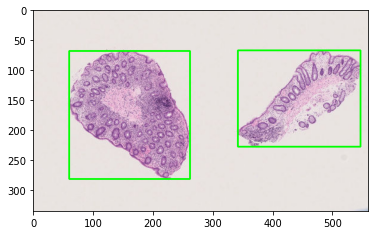

In [4]:
# openCVの輪郭検出機能を使って生検部位のROIを設定する
from PIL import Image
import cv2


#輪郭検出のために２値化
im_gray = cv2.cvtColor(small_img, cv2.COLOR_BGR2GRAY)
ret2,th2 = cv2.threshold(im_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#01変換
th2[th2==0]=1
th2[th2==255]=0

# 輪郭を抽出する。
contours, hierarchy = cv2.findContours(
    th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

# 検出された領域をrectangleで描写
area_num = 5000
contours_filtered = list(filter(lambda x: cv2.contourArea(x) > area_num, contours))

for i in contours_filtered:
    x,y,width,height = cv2.boundingRect(i)
    cv2.rectangle(small_img, (x,y),(x+width, y+height), color = (0,255,0), thickness =2 )
plt.imshow(small_img)


In [5]:
# セグメンテーションと物体検出のライブラリをインストール
!pip install segmentation_models_pytorch==0.2.1
!git clone https://github.com/ultralytics/yolov5
%cd /content/yolov5/
!pip install -qr requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5


In [6]:
# セグメンテーションモデルのロード

import segmentation_models_pytorch as smp
import torch
from tqdm import tqdm
import skimage.io
from skimage.transform import rescale, resize

ENCODER = "efficientnet-b4"
ENCODER_WEIGHTS = "imagenet"
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
DEVICE = "cuda"
seg_model = torch.load('/content/demo/seg_model.pth')

%cd /content/yolov5/
# 好中球検出モデルのロードと閾値の設定
neu_model = torch.hub.load("", "custom", path='/content/demo/neu_model.pt', source="local")
neu_model.conf = 0.5

/content/yolov5


YOLOv5 🚀 v7.0-128-gb96f35c Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5l summary: 367 layers, 46113663 parameters, 0 gradients
Adding AutoShape... 


(3424, 3232, 3)


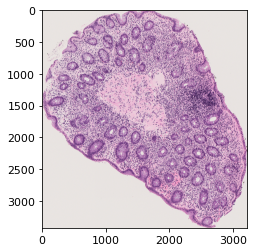

In [7]:
# まずひとつ目の検体をレベル1でとりだす
bx=0

#検出した検体を囲った矩形の座標リストを作る
specimen=[]
for i in contours_filtered:
    x,y,width,height = cv2.boundingRect(i)
    specimen.append([x,y,width,height ])

#検出された生検検体を左から順番に並べ直す
specimen=sorted(specimen) 
position=specimen[bx]
sp1=slide.read_region((position[0]*32, position[1]*32), 1, (position[2]*16,position[3]*16))
sp1_array = np.array(sp1)
sp1_array=np.array(sp1_array[:,:,0:3])
print(sp1_array.shape)
plt.imshow(sp1_array)

(3840, 3840, 3)


100%|██████████| 36/36 [00:03<00:00, 10.99it/s]


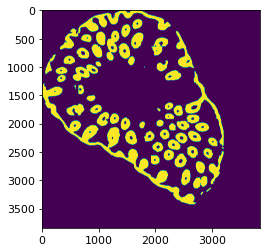

In [8]:
#上皮のマスクをセグメンテーション
#適応させるまえに縦横ともに640で割り切れるようにnp.zerosの行列を加えて整える



def crop_to_640pix(img):
    crop_array=img.reshape(int(img.shape[0]/640),640,int((img.shape[1])/640),640, 3)
    crop_array=crop_array.transpose([0,2,1,3,4])
    crop_array=crop_array.reshape(-1,640,640,3)
    return crop_array

def assemble_with640pix(crop_arrays, img_height, img_width):
    re_x=crop_arrays.reshape(int(img_height/640),int(img_width/640),640,640)
    re_x=re_x.transpose([0,2,1,3])
    return re_x.reshape(img_height, img_width).astype("uint8")

img=sp1_array
tile_size=640
add_space1=np.zeros((img.shape[0], tile_size-img.shape[1]%tile_size, 3))
img=np.hstack((img, add_space1)).astype("uint8")
add_space2=np.zeros((tile_size-img.shape[0]%tile_size, img.shape[1], 3))
img=np.vstack((img, add_space2)).astype("uint8")
print(img.shape)

#セグメンテーション
crop_array=crop_to_640pix(img)

epi_list=[]
for rgb in tqdm(crop_array):
    half_rgb=resize(rgb, (320, 320), anti_aliasing=True)
    image = preprocessing_fn(half_rgb)
    image = image.transpose(2, 0, 1).astype('float32')
    image=torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    predict = seg_model(image)
    predict = predict.detach().cpu().numpy()[0]
    pr_epithelium=predict[3,:,:]
    pr_epithelium = np.where(pr_epithelium>0.7, 1, 0)
    pr_epithelium=pr_epithelium.repeat(2, axis=0).repeat(2, axis=1)
    epi_list.append(pr_epithelium)
epi_arrays=np.stack(epi_list)
epi_arrays.shape
detect_epi=assemble_with640pix(epi_arrays, img.shape[0], img.shape[1])
#セグメンテーション結果の表示
plt.imshow(detect_epi)

In [9]:
# 検出した上皮内に浸潤した好中球を検出し、合計数を表示。

def crop_to_tile(img, tile_size):
    img=img[:int(img.shape[0]/tile_size)*tile_size, :int(img.shape[1]/tile_size)*tile_size]
    crop_array=img.reshape(int(img.shape[0]/tile_size),tile_size,int((img.shape[1])/tile_size),tile_size)
    crop_array=crop_array.transpose([0,2,1,3])
    crop_array=crop_array.reshape(-1,tile_size,tile_size)
    return crop_array

bai=32

pre_list=[]
epi_masks=crop_to_tile(detect_epi, 160)
neurophils=0

for i in tqdm(range(len(epi_masks))):
  if epi_masks[i].sum() > 100:
    # 上皮成分が存在するlevl0相当の320pixのタイルを取り出す
    width_bin=int(i%(detect_epi.shape[1]/160))
    height_bin=int(i//(detect_epi.shape[1]/160))
    crop_position=(int(position[0]*bai)+width_bin*320, int(position[1]*bai+height_bin*320))
    img = slide.read_region((crop_position), 0, (320,320))
    img_array = np.array(img)
    img_array=np.array(img_array[:,:,0:3])
    # 上皮マスクデータを作る
    epi_mask=cv2.resize(epi_masks[i], (320, 320))
    epi_tile = img_array*np.stack([epi_mask, epi_mask, epi_mask], axis=-1)
    # 上皮内の好中球検出
    neu_result = neu_model(epi_tile)
    neu_bb= neu_result.xyxy[0].to('cpu').detach().numpy().copy()
    # 好中球数のカウント
    neurophils= neurophils + (len(neu_bb))
    #見つけた好中球を示した画像をリストに入れる
    if len(neu_bb) > 0:
      for box in range(len(neu_bb)):
        cv2.rectangle(epi_tile,(int(neu_bb[box][0]), int(neu_bb[box][1])),(int(neu_bb[box][2]),int(neu_bb[box][3])), (255,0,0) , thickness=2)
      pre_list.append(epi_tile)
print("好中球数："+ str(neurophils) + "個")

100%|██████████| 576/576 [00:09<00:00, 59.01it/s] 

好中球数：392個


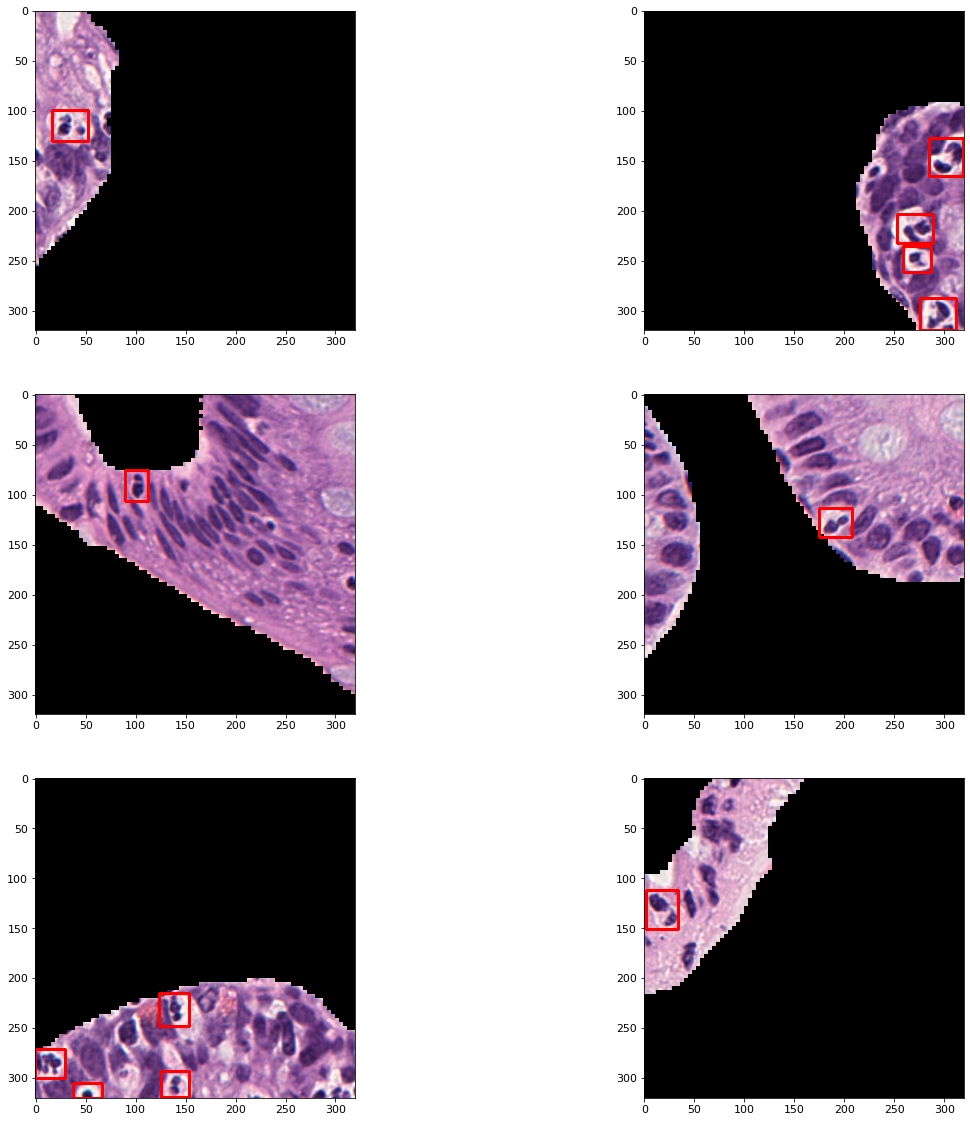

In [10]:
# 検出した好中球をランダムに6枚えらんで表示

import random
plt.rcParams['figure.figsize'] = (20.0, 20.0)
fig, axes = plt.subplots(nrows=3, ncols=2)
index_list=[random.randint(0, len(pre_list)) for p in range(0, 6)]
for j in range(6):
    axes[j//2, j%2].imshow(pre_list[index_list[j]])

In [11]:
# 次に2つ目をカウントしてみる
bx=1
pre_list=[]

position=specimen[bx]
sp1=slide.read_region((position[0]*32, position[1]*32), 1, (position[2]*16,position[3]*16))
sp1_array = np.array(sp1)
sp1_array=np.array(sp1_array[:,:,0:3])
img=sp1_array
tile_size=640
add_space1=np.zeros((img.shape[0], tile_size-img.shape[1]%tile_size, 3))
img=np.hstack((img, add_space1)).astype("uint8")
add_space2=np.zeros((tile_size-img.shape[0]%tile_size, img.shape[1], 3))
img=np.vstack((img, add_space2)).astype("uint8")

#セグメンテーション
crop_array=crop_to_640pix(img)

epi_list=[]
print("上皮のセグメンテーション…")
for rgb in tqdm(crop_array):
    half_rgb=resize(rgb, (320, 320), anti_aliasing=True)
    image = preprocessing_fn(half_rgb)
    image = image.transpose(2, 0, 1).astype('float32')
    image=torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    predict = seg_model(image)
    predict = predict.detach().cpu().numpy()[0]
    pr_epithelium=predict[3,:,:]
    pr_epithelium = np.where(pr_epithelium>0.7, 1, 0)
    pr_epithelium=pr_epithelium.repeat(2, axis=0).repeat(2, axis=1)
    epi_list.append(pr_epithelium)
epi_arrays=np.stack(epi_list)
detect_epi=assemble_with640pix(epi_arrays, img.shape[0], img.shape[1])
epi_masks=crop_to_tile(detect_epi, 160)
neurophils=0
print("好中球を計測…")
for i in tqdm(range(len(epi_masks))):
  if epi_masks[i].sum() > 100:
    # 上皮成分が存在するlevl0相当の320pixのタイルを取り出す
    width_bin=int(i%(detect_epi.shape[1]/160))
    height_bin=int(i//(detect_epi.shape[1]/160))
    crop_position=(int(position[0]*bai)+width_bin*320, int(position[1]*bai+height_bin*320))
    img = slide.read_region((crop_position), 0, (320,320))
    img_array = np.array(img)
    img_array=np.array(img_array[:,:,0:3])
    # 上皮マスクデータを作る
    epi_mask=cv2.resize(epi_masks[i], (320, 320))
    epi_tile = img_array*np.stack([epi_mask, epi_mask, epi_mask], axis=-1)
    # 上皮内の好中球検出
    neu_result = neu_model(epi_tile)
    neu_bb= neu_result.xyxy[0].to('cpu').detach().numpy().copy()
    # 好中球数のカウント
    neurophils= neurophils + (len(neu_bb))
    #見つけた好中球を示した画像をリストに入れる
    if len(neu_bb) > 0:
      for box in range(len(neu_bb)):
        cv2.rectangle(epi_tile,(int(neu_bb[box][0]), int(neu_bb[box][1])),(int(neu_bb[box][2]),int(neu_bb[box][3])), (255,0,0) , thickness=2)
      pre_list.append(epi_tile)
print("好中球数："+ str(neurophils) + "個")


上皮のセグメンテーション…


100%|██████████| 30/30 [00:02<00:00, 11.42it/s]


好中球を計測…


100%|██████████| 480/480 [00:04<00:00, 105.35it/s]

好中球数：6個


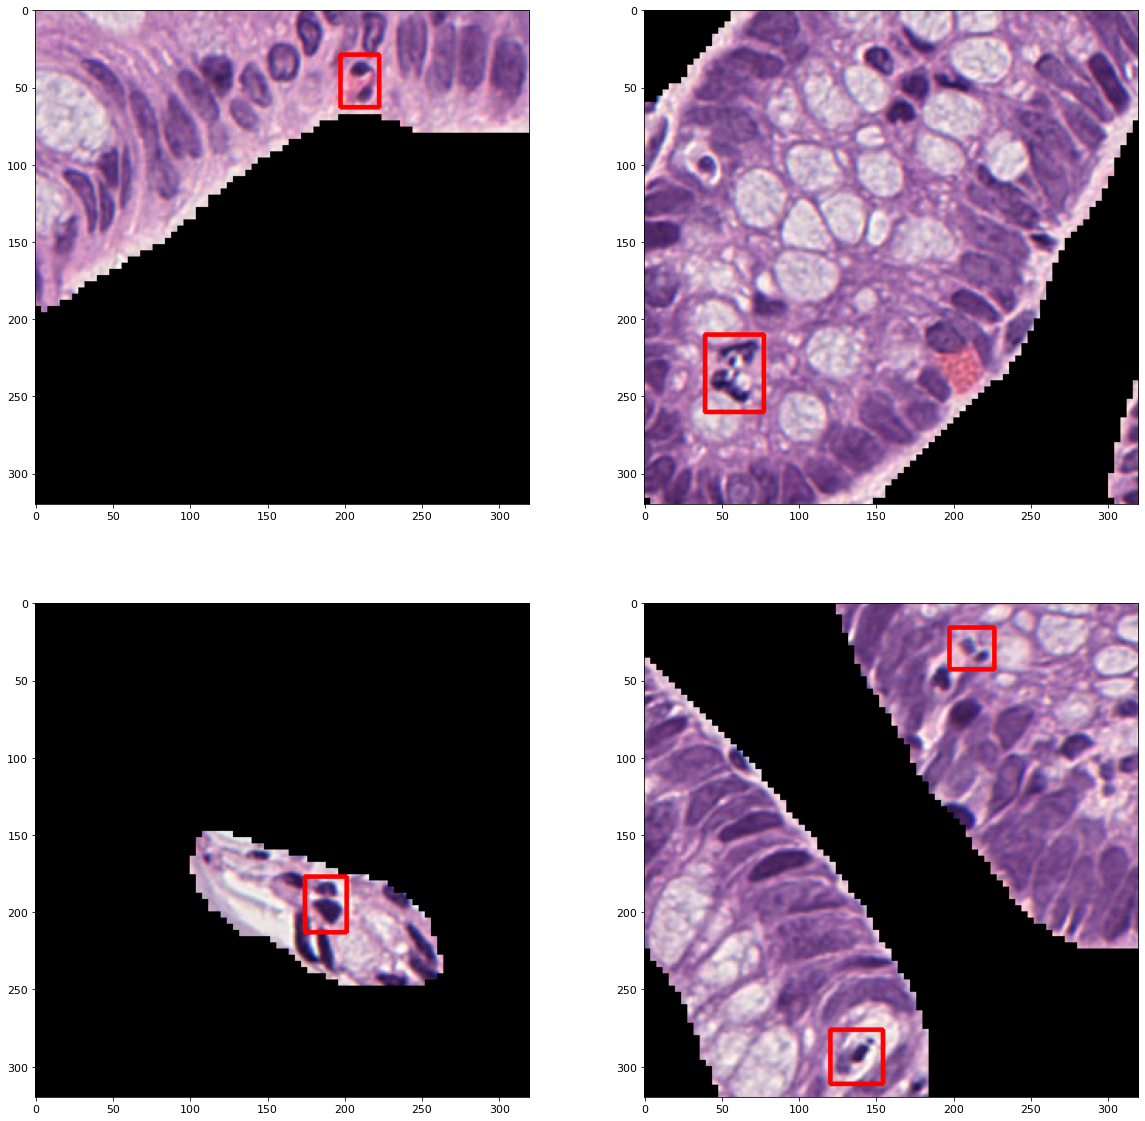

In [12]:
# 検出した好中球を確認
fig, axes = plt.subplots(nrows=2, ncols=2)
for j in range(4):
    axes[j//2, j%2].imshow(pre_list[j])